# Data Preparation

In [1]:
#Mounting Google Drive files
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Unzipping the Dataset Required
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/TFG/DataSets/Correct Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
with zipfile.ZipFile('/content/drive/MyDrive/TFG/DataSets/ColouredMasks.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [3]:
#Save images names
from pathlib import Path
import os
path = Path('/content/Correct Dataset/')
RetImgs = [i  for i in os.listdir(path/'RET')]

In [4]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

#Saving Original Images and Coloured Masks in RAM

IRetImgs = []
path = '/content/Correct Dataset'

#Original images
#Append
for i in RetImgs:
    IRetImgs.append(plt.imread(path + '/Original/' +i)) 

#Saving shapes (for later resize)
shape_img = []
for i in range(len(IRetImgs)): 
  shape_img.append(IRetImgs[i].shape)
  
#Resize
for i in range(len(IRetImgs)):
 size = (512,512)
 IRetImgs[i] = cv2.resize(IRetImgs[i],size)
#Save as numpy array
IRetImgs = np.array(IRetImgs)

#Coloured Masks
ColouredMasks = []
for i in RetImgs: 
  ColouredMasks.append(plt.imread('/content/ColouredMasks/' + i,-1))


In [5]:
#Doing One Hot to the masks
def OneHot(mask):
  OH = (np.arange(5) == mask[...,None]).astype(np.float32)
  OH = np.transpose(OH,(2,0,1))
  return OH

In [6]:
#Cojo mascaras del Dataset tratado y las añado en una unica imagen con colores por capa
def color_mask(path,name):
  Layers_Colour = ['/EP/', '/EP_PR/', '/PR/', '/REST_RET/']
  MaskLayer = []
  for j in Layers_Colour: 
    MaskLayer.append(plt.imread(path + j + name))
  MaskColor = MaskLayer[0] + MaskLayer[1]*2 + MaskLayer[2]*3 + MaskLayer[3]*4
  return MaskColor

In [7]:
#Treatment applied to wrong masks in order to avoid wrong values
def Treatment(img,size): 
  image = cv2.resize(img,size)
  for i in range(10):
    for i in range(image.shape[1]): 
      for j in range(image.shape[0]): 
        try:
          if (image[j,i]!=1) and (image[j,i]!=2) and (image[j,i]!=3) and (image[j,i]!=4) and (image[j,i]!=0):
            image[j,i] = image[j+1,i]
          if (image[j,i]!=image[j-1,i]) and ((image[j,i]!=image[j+1,i])):
            image[j,i] = image[j+1,i]
        except:
          continue
  OH = (np.arange(5) == image[...,None]).astype(np.float32)
  OH = np.transpose(OH,(2,0,1))
  return OH

In [8]:
#Changing from One Hot to Colour Mask
def OH2COLOR(mask_Oh):
  mask_Oh = np.array(mask_Oh)
  mask = np.zeros((mask_Oh.shape[1],mask_Oh.shape[2]))
  for j in range(mask_Oh.shape[0]):
    mask += mask_Oh[j]*j
  return mask

Al hacer el resize pierdo calidad y la recupero con este código. Basicamente recorre la imagen por columnas desde arriba y si detecta que el color no corresponde con los posibles, el pixel se recolorea con el color del pixel inferior. Si se queda alguno mal entre dos bien tbn lo recolorea

#Dataset and Dataloader definition

In [160]:
#Creating Dataset Class
import torch
class Dataset(torch.utils.data.Dataset):
  def __init__(self, OriginalImgs, ColouredMasks, n_classes=5, augmentation=None):
    self.names = OriginalImgs
    self.n_classes = n_classes
    self.augmentation = augmentation
    self.color_mask = ColouredMasks
  def __len__(self):
    return len(self.names)

  def __getitem__(self, ix):
    OH = OneHot(self.color_mask[ix])
    img = self.names[ix]
    img = torch.tensor(img).unsqueeze(0)
    return img,OH

In [192]:
#Definicion del dataset
#@title Dataset Definition
Augmentation = False
Train_Length =     600#@param {type:"number"}
dataset = {
    'train': Dataset(IRetImgs[:Train_Length], ColouredMasks[:Train_Length]),
    'test': Dataset(IRetImgs[Train_Length:], ColouredMasks[Train_Length:])
}

In [162]:
#Definicion del dataloader
#@title Dataloader Definition
#Con deeplabv3 el batch_size no puede ser 1

BatchSize =     4#@param {type:"number"}
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BatchSize, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=BatchSize, pin_memory=True)
}

# Metrics

In [163]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N): #saltamos el background si pongo N-1
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [164]:
def accuracy(y_pred,color_mask):
    num = np.sum(np.array(y_pred == color_mask))  
    a,b = y_pred.shape
    den = a*b
    acc = (num/den)
    return acc

# GPU Acceleration

In [165]:
#Aceleracion por GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Architectures

In [166]:
from torchvision.models.segmentation import fcn_resnet50
import torch

resnet_50 = fcn_resnet50(pretrained=False, num_classes = 5, aux_loss = False ) 
resnet_50.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [167]:
from torchvision.models.segmentation import fcn_resnet101
resnet_101 = fcn_resnet101(pretrained=False, num_classes = 5, aux_loss = False)
resnet_101.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [168]:
from torchvision.models.segmentation import deeplabv3_resnet50
deeplabv3_resnet50_train =deeplabv3_resnet50(pretrained=False, progress=True, num_classes=5, aux_loss=None)
deeplabv3_resnet50_train.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [169]:
from torchvision.models.segmentation import deeplabv3_resnet101
deeplabv3_resnet101_train =deeplabv3_resnet101(pretrained=False, progress=True, num_classes=5, aux_loss=None)
deeplabv3_resnet101_train.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Multiprocessing

In [170]:
#@title Multiprocessing: recommended use when GPU is not available { vertical-output: true }
Multiprocessing = False    #@param {type:"boolean"}
if Multiprocessing==True:
  device = 'cpu'

# Training functions

In [178]:
#Entrenamiento del modelo
#@title Training Parameters { vertical-output: true }

#import ipywidgets as widgets
#from IPython.display import display

ModelArchitecture = "resnet_50" #@param ["resnet_50", "resnet_101", "deeplabv3_resnet50", "deeplabv3_resnet101"]
LearningRate =  0.1   #@param {type:"number"}
Epochs =  1    #@param {type:"number"}
EarlyStopping =  5    #@param {type:"number"}
params = {'model': '', 'model_name': ModelArchitecture, 'lr': LearningRate, 'epochs': Epochs, 'early_stopping': EarlyStopping}

if ModelArchitecture=='resnet_50':
  params['model']  = resnet_50
elif ModelArchitecture=='resnet_101':
  params['model']  = resnet_101
elif ModelArchitecture=='deeplabv3_resnet50':
  params['model']  = deeplabv3_resnet50_train
elif ModelArchitecture=='deeplabv3_resnet101':
  params['model']  = deeplabv3_resnet101_train

In [179]:
!pip install torchmetrics

In [180]:
from tqdm import tqdm
import torchmetrics
from torchmetrics import ConfusionMatrix

def fit(model, model_name, dataloader, epochs=10, lr=0.01, early_stopping=0):
    torch.cuda.empty_cache()
    #Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #Función de pérdida
    criterion = torch.nn.BCEWithLogitsLoss()

    model.to(device)
    hist = {'Loss': [], 'IoU': [], 'AccuracyScore': [], 'TestLoss': [], 'TestIoU': [], 'TestAcc': []}

    if early_stopping:
        step = 0
        best_acc, best_IoU, best_loss = 0,0,1e6
        weight_loss = 0.035

    for epoch in range(1, epochs+1):
      #Entrenamiento
      num_classes = 5
      TrainConfusionMatrixShown = torch.zeros(num_classes,num_classes)
      TestConfusionMatrixShown = torch.zeros(num_classes,num_classes)
      model.train()
      bar = tqdm(dataloader['train'])
      train_loss, train_iou, train_acc,CM_pred,CM_actual_CM,y_hat_CM,CM_array = [], [], [], [] , [] , [] , []
      i=0
      for imgs, mask_oh in bar:
        i+=1
        # Guardar imagenes en GPU
        imgs, mask_oh = imgs.to(device), mask_oh.to(device)
        len_mask_oh = len(mask_oh)
        # Poner los gradientes a 0 porque si no son acumulativos
        optimizer.zero_grad()
        #Calculo de Output
       
        y_hat = model(imgs)
        
        #CUIDADO CON EL OUTPUT. ES DISTINTO DE LA UNET Y DE RESNET
        if model_name != 'UNet':
          y_hat = y_hat['out']
        #Métricas
        #Loss
        loss = criterion(y_hat, mask_oh)
        loss.backward()
        train_loss.append(loss.item())
        del loss
        #Accuracy
        acc = []
        mask_OH = mask_oh.cpu()
        for i in range(y_hat.shape[0]):
          mask = OH2COLOR(mask_OH[i])
          pred_mask = torch.argmax(y_hat[i], axis=0)
          acc.append(accuracy(np.array(pred_mask.cpu()),mask) )
        acc = np.mean(np.array(acc))
        train_acc.append(acc)
        del acc
        #IoU
        ious = iou(y_hat, mask_oh)
        train_iou.append(ious)
        del ious
        #Confusion Matrix
        for i in range(y_hat.shape[0]):
          mask = OH2COLOR(mask_OH[i])
          pred_mask = torch.argmax(y_hat[i], axis=0)
          CM = ConfusionMatrix(num_classes = 5)       
          TrainConfusionMatrixShown+=CM(pred_mask.cpu(),torch.tensor(mask.astype(int)).cpu())
        #Optimizacion
        optimizer.step()
        del imgs, mask_oh
        del y_hat

      hist['Loss'].append(np.mean(train_loss))
      hist['IoU'].append(np.mean(train_iou))
      hist['AccuracyScore'].append(np.mean(train_acc))
      
      #Test
      model.eval()
      bar = tqdm(dataloader['test'])
      test_loss, test_iou, test_acc = [], [], []
      with torch.no_grad():
        i=0
        for imgs, mask_oh in bar:
          i+=1
          #Guardar imagenes en GPU
          imgs, mask_oh = imgs.to(device), mask_oh.to(device)
          len_mask_oh = len(mask_oh)
          #Calculo de output
          y_hat = model(imgs)
          if model_name != 'UNet':
            y_hat = y_hat['out']
          #Calculo de métricas
          #Loss
          loss = criterion(y_hat, mask_oh)
          print(loss.shape)
          test_loss.append(loss.item())
          del loss
          #Accuracy
          acc = []
          mask_OH = mask_oh.cpu()
          for i in range(y_hat.shape[0]):
            mask = OH2COLOR(mask_OH[i])
            pred_mask = torch.argmax(y_hat[i], axis=0)
            acc.append(accuracy(np.array(pred_mask.cpu()),mask) )
          acc = np.mean(np.array(acc))
          test_acc.append(acc)
          del acc
          #IoU
          ious = iou(y_hat, mask_oh)
          test_iou.append(ious)
          del ious
          #Confusion Matrix
          for i in range(y_hat.shape[0]):
            mask = OH2COLOR(mask_OH[i])
            pred_mask = torch.argmax(y_hat[i], axis=0)
            CM = ConfusionMatrix(num_classes = 5)       
            TestConfusionMatrixShown+=CM(pred_mask.cpu(),torch.tensor(mask.astype(int)).cpu())
          
      hist['TestLoss'].append(np.mean(test_loss))
      hist['TestIoU'].append(np.mean(test_iou))
      hist['TestAcc'].append(np.mean(test_acc))
      print(f"\nEpoch {epoch}/{epochs} TrainLoss {np.mean(train_loss):.5f} TrainIoU {np.mean(train_iou):.5f} TrainAccuracy {np.mean(train_acc):.5f} TestLoss {np.mean(test_loss):.5f} TestIoU {np.mean(test_iou):.5f} TestAcc {np.mean(test_acc):.5f} Learning Rate {lr}")
      print(f"\n TrainConfusionMatrix {TrainConfusionMatrixShown} \n TestConfusionMatrix {TestConfusionMatrixShown}")
      best_metric = (best_loss)**-1*weight_loss + best_IoU + best_acc
      actual_metric = ((hist['TestLoss'][-1])**-1*weight_loss + hist['TestIoU'][-1] + hist['TestAcc'][-1])
      #Early stopping code
      if actual_metric > best_metric:
          best_loss, best_IoU, best_acc = hist['TestLoss'][-1], hist['TestIoU'][-1], hist['TestAcc'][-1]
          print(f'Best model saved with learning rate {lr} in epoch {epoch}')
          #torch.save(model.state_dict(), f'{model_name}_lr_{lr}.pt')
          #It downloads the pretrained model 
          torch.save(model.state_dict(),'/content/drive/MyDrive/TFG/Modelos/Models Multilayer/Pretrained Models/'+f'{model_name}_lr_{lr}.pt' )
          step = 0
      else:
          step+=1
      if step>early_stopping: 
          print(f'Code stopped by early stopping. Best metrics are: TestAccuracy: {best_acc}, TestLoss: {best_loss}, TestIoU: {best_IoU}')
          break
          #break exits de epoch loop
    #Load best parameters in model (Hacer esto al evaluar segun learning rate, ya que tendré varios modelos, no me interesa cargarlo ahora)
    model.load_state_dict(torch.load('/content/drive/MyDrive/TFG/Modelos/Models Multilayer/Pretrained Models/'+f'{model_name}_lr_{lr}.pt'))
    model.to('cpu')
    torch.cuda.empty_cache()
    return hist,best_loss,best_IoU,best_acc

In [181]:
from tqdm import tqdm

def fit_multi(model, model_name, dataloader, epochs=10, lr=0.01, early_stopping=0):
    #torch.cuda.empty_cache()
    #Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #Función de pérdida
    criterion = torch.nn.BCEWithLogitsLoss()

    #model.to(device)
    hist = {'Loss': [], 'IoU': [], 'AccuracyScore': [], 'TestLoss': [], 'TestIoU': [], 'TestAcc': []}

    if early_stopping:
        step = 0
        best_acc, best_IoU, best_loss = 0,0,1e6
        weight_loss = 0.035

    for epoch in range(1, epochs+1):
      #Entrenamiento
      num_classes = 5
      TrainConfusionMatrixShown = torch.zeros(num_classes,num_classes)
      TestConfusionMatrixShown = torch.zeros(num_classes,num_classes)
      model.train()
      #bar = tqdm(dataloader['train'])
      #For multiprocessing, change to only dataloader
      bar = tqdm(dataloader)
      train_loss, train_iou, train_acc,CM_pred,CM_actual_CM,y_hat_CM,CM_array = [], [], [], [] , [] , [] , []
      i=0
      for imgs, mask_oh in bar:
        i+=1
        # Guardar imagenes en GPU
        #imgs, mask_oh = imgs.to(device), mask_oh.to(device)
        len_mask_oh = len(mask_oh)
        # Poner los gradientes a 0 porque si no son acumulativos
        optimizer.zero_grad()
        #Calculo de Output
       
        y_hat = model(imgs)
        
        #CUIDADO CON EL OUTPUT. ES DISTINTO DE LA UNET Y DE RESNET
        if model_name != 'UNet':
          y_hat = y_hat['out']
        #Métricas
        #Loss
        loss = criterion(y_hat, mask_oh)
        loss.backward()
        train_loss.append(loss.item())
        del loss
        #Accuracy
        acc = []
        mask_OH = mask_oh.cpu()
        for i in range(y_hat.shape[0]):
          mask = OH2COLOR(mask_OH[i])
          pred_mask = torch.argmax(y_hat[i], axis=0)
          acc.append(accuracy(np.array(pred_mask.cpu()),mask) )
        acc = np.mean(np.array(acc))
        train_acc.append(acc)
        del acc
        #IoU
        ious = iou(y_hat, mask_oh)
        train_iou.append(ious)
        del ious
        #Confusion Matrix
        for i in range(y_hat.shape[0]):
          mask = OH2COLOR(mask_OH[i])
          pred_mask = torch.argmax(y_hat[i], axis=0)
          CM = ConfusionMatrix(num_classes = 5)       
          TrainConfusionMatrixShown+=CM(pred_mask.cpu(),torch.tensor(mask.astype(int)).cpu())
        #Optimizacion
        optimizer.step()
        del imgs, mask_oh
       
        #Visualizar métricas
        #bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} accuracy {np.mean(train_acc):.5f}")
        #print(confusion_matrix)

        del y_hat

      hist['Loss'].append(np.mean(train_loss))
      hist['IoU'].append(np.mean(train_iou))
      hist['AccuracyScore'].append(np.mean(train_acc))
      
      #Test
      model.eval()
      #bar = tqdm(dataloader['train'])
      #For multiprocessing, change to only dataloader
      bar = tqdm(dataloader)
      test_loss, test_iou, test_acc = [], [], []
      with torch.no_grad():
        i=0
        for imgs, mask_oh in bar:
          i+=1
          #Guardar imagenes en GPU
          #imgs, mask_oh = imgs.to(device), mask_oh.to(device)
          len_mask_oh = len(mask_oh)
          #Calculo de output
          y_hat = model(imgs)
          if model_name != 'UNet':
            y_hat = y_hat['out']
          #Calculo de métricas
          #Loss
          loss = criterion(y_hat, mask_oh)
          test_loss.append(loss.item())
          del loss
          #Accuracy
          acc = []
          mask_OH = mask_oh.cpu()
          imgs.cpu()
          for i in range(y_hat.shape[0]):
            mask = OH2COLOR(mask_OH[i])
            pred_mask = torch.argmax(y_hat[i], axis=0)
            acc.append(accuracy(np.array(pred_mask.cpu()),mask) )
          acc = np.mean(np.array(acc))
          test_acc.append(acc)
          del acc
          #IoU
          ious = iou(y_hat, mask_oh)
          test_iou.append(ious)
          del ious
          #Confusion Matrix
          for i in range(y_hat.shape[0]):
            mask = OH2COLOR(mask_OH[i])
            pred_mask = torch.argmax(y_hat[i], axis=0)
            CM = ConfusionMatrix(num_classes = 5)       
            TestConfusionMatrixShown+=CM(pred_mask.cpu(),torch.tensor(mask.astype(int)).cpu())
          
      hist['TestLoss'].append(np.mean(test_loss))
      hist['TestIoU'].append(np.mean(test_iou))
      hist['TestAcc'].append(np.mean(test_acc))
      print(f"\nEpoch {epoch}/{epochs} TrainLoss {np.mean(train_loss):.5f} TrainIoU {np.mean(train_iou):.5f} TrainAccuracy {np.mean(train_acc):.5f} TestLoss {np.mean(test_loss):.5f} TestIoU {np.mean(test_iou):.5f} TestAcc {np.mean(test_acc):.5f} Learning Rate {lr}")
      
      best_metric = (best_loss)**-1*weight_loss + best_IoU + best_acc
      actual_metric = ((hist['TestLoss'][-1])**-1*weight_loss + hist['TestIoU'][-1] + hist['TestAcc'][-1])
      #Early stopping code
      if actual_metric > best_metric:
          best_loss, best_IoU, best_acc = hist['TestLoss'][-1], hist['TestIoU'][-1], hist['TestAcc'][-1]
          print(f'Best model saved with learning rate {lr} in epoch {epoch}')
          #torch.save(model.state_dict(), f'{model_name}_lr_{lr}.pt')
          #It downloads the pretrained model 
          torch.save(model.state_dict(),'/content/drive/MyDrive/TFG/Modelos/Models Multilayer/Pretrained Models/'+f'{model_name}_lr_{lr}.pt' )
          step = 0
      else:
          step+=1
      if step>early_stopping: 
          print(f'Code stopped by early stopping. Best metrics are: TestAccuracy: {best_acc}, TestLoss: {best_loss}, TestIoU: {best_IoU}')
          break
          #break exits de epoch loop
    #Load best parameters in model (Hacer esto al evaluar segun learning rate, ya que tendré varios modelos, no me interesa cargarlo ahora)
    #model.load_state_dict(torch.load(f'{model_name}_lr_{lr}.pt'))
    model.load_state_dict(torch.load('/content/drive/MyDrive/TFG/Modelos/Models Multilayer/Pretrained Models/'+f'{model_name}_lr_{lr}.pt'))
    #model.to('cpu')
    #torch.cuda.empty_cache()
    return hist,best_loss,best_IoU,best_acc

# Training visualization

Multiprocessing visualization

In [182]:
if (__name__ == '__main__') and (Multiprocessing==True):
  import multiprocessing as mp
  num_processes = mp.cpu_count()
  model = params['model']
  model_name = params['model_name']
  model.share_memory()
  processes = []
  for rank in range(num_processes):
      data_loader = torch.utils.data.DataLoader(
          dataset=dataset['train'],
          sampler=torch.utils.data.DistributedSampler(
              dataset=dataset['train'],
              num_replicas=num_processes,
              rank=rank
          ),
          batch_size=BatchSize
      )
      p = mp.Process(target=fit_multi, args=(model, model_name, data_loader, 10, 0.01, 10))
      p.start()
      processes.append(p)
  for p in processes:
    p.join()

GPU visualization

In [187]:
hist = []
if Multiprocessing==False:
  model = params['model']
  historial,best_loss,best_IoU,best_acc = fit(model, params['model_name'], dataloader, params['epochs'], lr=params['lr'], early_stopping=params['early_stopping'])
  hist.append(historial)

  0%|          | 0/172 [00:00<?, ?it/s]

torch.Size([])


  1%|          | 1/172 [00:02<06:25,  2.25s/it]

torch.Size([])


  1%|          | 2/172 [00:04<06:27,  2.28s/it]

torch.Size([])


  2%|▏         | 3/172 [00:06<06:22,  2.26s/it]

torch.Size([])


  2%|▏         | 4/172 [00:09<06:18,  2.25s/it]

torch.Size([])


  3%|▎         | 5/172 [00:11<06:16,  2.26s/it]

torch.Size([])


  3%|▎         | 6/172 [00:13<06:19,  2.29s/it]

torch.Size([])


  4%|▍         | 7/172 [00:15<06:18,  2.29s/it]

torch.Size([])


  5%|▍         | 8/172 [00:18<06:13,  2.27s/it]

torch.Size([])


  5%|▌         | 9/172 [00:20<06:11,  2.28s/it]

torch.Size([])


  6%|▌         | 10/172 [00:22<06:06,  2.26s/it]

torch.Size([])


  6%|▋         | 11/172 [00:24<06:04,  2.26s/it]

torch.Size([])


  7%|▋         | 12/172 [00:27<06:01,  2.26s/it]

torch.Size([])


  8%|▊         | 13/172 [00:29<05:58,  2.26s/it]

torch.Size([])


  8%|▊         | 14/172 [00:31<05:59,  2.28s/it]

torch.Size([])


  9%|▊         | 15/172 [00:34<05:56,  2.27s/it]

torch.Size([])


  9%|▉         | 16/172 [00:36<05:53,  2.27s/it]

torch.Size([])


 10%|▉         | 17/172 [00:38<05:50,  2.26s/it]

torch.Size([])


 10%|█         | 18/172 [00:40<05:48,  2.26s/it]

torch.Size([])


 11%|█         | 19/172 [00:43<05:44,  2.25s/it]

torch.Size([])


 12%|█▏        | 20/172 [00:45<05:42,  2.25s/it]

torch.Size([])


 12%|█▏        | 21/172 [00:47<05:43,  2.28s/it]

torch.Size([])


 13%|█▎        | 22/172 [00:49<05:42,  2.28s/it]

torch.Size([])


 13%|█▎        | 23/172 [00:52<05:39,  2.28s/it]

torch.Size([])


 14%|█▍        | 24/172 [00:54<05:37,  2.28s/it]

torch.Size([])


 15%|█▍        | 25/172 [00:56<05:35,  2.29s/it]

torch.Size([])


 15%|█▌        | 26/172 [00:59<05:34,  2.29s/it]

torch.Size([])


 16%|█▌        | 27/172 [01:01<05:30,  2.28s/it]

torch.Size([])


 16%|█▋        | 28/172 [01:03<05:30,  2.29s/it]

torch.Size([])


 17%|█▋        | 29/172 [01:05<05:28,  2.30s/it]

torch.Size([])


 17%|█▋        | 30/172 [01:08<05:25,  2.30s/it]

torch.Size([])


 18%|█▊        | 31/172 [01:10<05:22,  2.29s/it]

torch.Size([])


 19%|█▊        | 32/172 [01:12<05:20,  2.29s/it]

torch.Size([])


 19%|█▉        | 33/172 [01:15<05:18,  2.29s/it]

torch.Size([])


 20%|█▉        | 34/172 [01:17<05:18,  2.31s/it]

torch.Size([])


 20%|██        | 35/172 [01:19<05:18,  2.32s/it]

torch.Size([])


 21%|██        | 36/172 [01:22<05:15,  2.32s/it]

torch.Size([])


 22%|██▏       | 37/172 [01:24<05:13,  2.32s/it]

torch.Size([])


 22%|██▏       | 38/172 [01:26<05:12,  2.33s/it]

torch.Size([])


 23%|██▎       | 39/172 [01:29<05:10,  2.34s/it]

torch.Size([])


 23%|██▎       | 40/172 [01:31<05:09,  2.34s/it]

torch.Size([])


 24%|██▍       | 41/172 [01:33<05:06,  2.34s/it]

torch.Size([])


 24%|██▍       | 42/172 [01:36<05:04,  2.35s/it]

torch.Size([])


 25%|██▌       | 43/172 [01:38<05:03,  2.35s/it]

torch.Size([])


 26%|██▌       | 44/172 [01:40<05:01,  2.36s/it]

torch.Size([])


 26%|██▌       | 45/172 [01:43<04:58,  2.35s/it]

torch.Size([])


 27%|██▋       | 46/172 [01:45<04:57,  2.36s/it]

torch.Size([])


 27%|██▋       | 47/172 [01:48<04:54,  2.36s/it]

torch.Size([])


 28%|██▊       | 48/172 [01:50<04:52,  2.36s/it]

torch.Size([])


 28%|██▊       | 49/172 [01:52<04:49,  2.35s/it]

torch.Size([])


 29%|██▉       | 50/172 [01:55<04:47,  2.36s/it]

torch.Size([])


 30%|██▉       | 51/172 [01:57<04:43,  2.35s/it]

torch.Size([])


 30%|███       | 52/172 [01:59<04:41,  2.35s/it]

torch.Size([])


 31%|███       | 53/172 [02:02<04:39,  2.35s/it]

torch.Size([])


 31%|███▏      | 54/172 [02:04<04:36,  2.35s/it]

torch.Size([])


 32%|███▏      | 55/172 [02:06<04:33,  2.34s/it]

torch.Size([])


 33%|███▎      | 56/172 [02:09<04:32,  2.35s/it]

torch.Size([])


 33%|███▎      | 57/172 [02:11<04:29,  2.34s/it]

torch.Size([])


 34%|███▎      | 58/172 [02:13<04:27,  2.35s/it]

torch.Size([])


 34%|███▍      | 59/172 [02:16<04:24,  2.34s/it]

torch.Size([])


 35%|███▍      | 60/172 [02:18<04:22,  2.35s/it]

torch.Size([])


 35%|███▌      | 61/172 [02:20<04:20,  2.35s/it]

torch.Size([])


 36%|███▌      | 62/172 [02:23<04:17,  2.34s/it]

torch.Size([])


 37%|███▋      | 63/172 [02:25<04:15,  2.34s/it]

torch.Size([])


 37%|███▋      | 64/172 [02:27<04:12,  2.34s/it]

torch.Size([])


 38%|███▊      | 65/172 [02:30<04:08,  2.32s/it]

torch.Size([])


 38%|███▊      | 66/172 [02:32<04:05,  2.32s/it]

torch.Size([])


 39%|███▉      | 67/172 [02:34<04:02,  2.31s/it]

torch.Size([])


 40%|███▉      | 68/172 [02:37<03:59,  2.30s/it]

torch.Size([])


 40%|████      | 69/172 [02:39<03:56,  2.30s/it]

torch.Size([])


 41%|████      | 70/172 [02:41<03:54,  2.30s/it]

torch.Size([])


 41%|████▏     | 71/172 [02:43<03:51,  2.29s/it]

torch.Size([])


 42%|████▏     | 72/172 [02:46<03:49,  2.30s/it]

torch.Size([])


 42%|████▏     | 73/172 [02:48<03:47,  2.30s/it]

torch.Size([])


 43%|████▎     | 74/172 [02:50<03:46,  2.31s/it]

torch.Size([])


 44%|████▎     | 75/172 [02:53<03:43,  2.30s/it]

torch.Size([])


 44%|████▍     | 76/172 [02:55<03:41,  2.31s/it]

torch.Size([])


 45%|████▍     | 77/172 [02:57<03:39,  2.31s/it]

torch.Size([])


 45%|████▌     | 78/172 [03:00<03:37,  2.31s/it]

torch.Size([])


 46%|████▌     | 79/172 [03:02<03:34,  2.31s/it]

torch.Size([])


 47%|████▋     | 80/172 [03:04<03:32,  2.31s/it]

torch.Size([])


 47%|████▋     | 81/172 [03:07<03:30,  2.31s/it]

torch.Size([])


 48%|████▊     | 82/172 [03:09<03:27,  2.31s/it]

torch.Size([])


 48%|████▊     | 83/172 [03:11<03:25,  2.31s/it]

torch.Size([])


 49%|████▉     | 84/172 [03:13<03:22,  2.30s/it]

torch.Size([])


 49%|████▉     | 85/172 [03:16<03:19,  2.30s/it]

torch.Size([])


 50%|█████     | 86/172 [03:18<03:17,  2.29s/it]

torch.Size([])


 51%|█████     | 87/172 [03:20<03:14,  2.29s/it]

torch.Size([])


 51%|█████     | 88/172 [03:23<03:12,  2.29s/it]

torch.Size([])


 52%|█████▏    | 89/172 [03:25<03:10,  2.30s/it]

torch.Size([])


 52%|█████▏    | 90/172 [03:27<03:07,  2.28s/it]

torch.Size([])


 53%|█████▎    | 91/172 [03:29<03:04,  2.28s/it]

torch.Size([])


 53%|█████▎    | 92/172 [03:32<03:04,  2.31s/it]

torch.Size([])


 54%|█████▍    | 93/172 [03:34<03:02,  2.31s/it]

torch.Size([])


 55%|█████▍    | 94/172 [03:36<03:00,  2.31s/it]

torch.Size([])


 55%|█████▌    | 95/172 [03:39<02:57,  2.30s/it]

torch.Size([])


 56%|█████▌    | 96/172 [03:41<02:54,  2.29s/it]

torch.Size([])


 56%|█████▋    | 97/172 [03:43<02:51,  2.28s/it]

torch.Size([])


 57%|█████▋    | 98/172 [03:45<02:47,  2.27s/it]

torch.Size([])


 58%|█████▊    | 99/172 [03:48<02:44,  2.26s/it]

torch.Size([])


 58%|█████▊    | 100/172 [03:50<02:42,  2.25s/it]

torch.Size([])


 59%|█████▊    | 101/172 [03:52<02:40,  2.26s/it]

torch.Size([])


 59%|█████▉    | 102/172 [03:54<02:37,  2.26s/it]

torch.Size([])


 60%|█████▉    | 103/172 [03:57<02:35,  2.25s/it]

torch.Size([])


 60%|██████    | 104/172 [03:59<02:33,  2.25s/it]

torch.Size([])


 61%|██████    | 105/172 [04:01<02:30,  2.25s/it]

torch.Size([])


 62%|██████▏   | 106/172 [04:03<02:28,  2.25s/it]

torch.Size([])


 62%|██████▏   | 107/172 [04:06<02:26,  2.26s/it]

torch.Size([])


 63%|██████▎   | 108/172 [04:08<02:23,  2.25s/it]

torch.Size([])


 63%|██████▎   | 109/172 [04:10<02:21,  2.25s/it]

torch.Size([])


 64%|██████▍   | 110/172 [04:12<02:20,  2.26s/it]

torch.Size([])


 65%|██████▍   | 111/172 [04:15<02:17,  2.25s/it]

torch.Size([])


 65%|██████▌   | 112/172 [04:17<02:15,  2.25s/it]

torch.Size([])


 66%|██████▌   | 113/172 [04:19<02:12,  2.25s/it]

torch.Size([])


 66%|██████▋   | 114/172 [04:21<02:10,  2.25s/it]

torch.Size([])


 67%|██████▋   | 115/172 [04:24<02:08,  2.25s/it]

torch.Size([])


 67%|██████▋   | 116/172 [04:26<02:06,  2.25s/it]

torch.Size([])


 68%|██████▊   | 117/172 [04:28<02:03,  2.25s/it]

torch.Size([])


 69%|██████▊   | 118/172 [04:30<02:01,  2.25s/it]

torch.Size([])


 69%|██████▉   | 119/172 [04:33<01:59,  2.26s/it]

torch.Size([])


 70%|██████▉   | 120/172 [04:35<01:57,  2.25s/it]

torch.Size([])


 70%|███████   | 121/172 [04:37<01:55,  2.27s/it]

torch.Size([])


 71%|███████   | 122/172 [04:40<01:53,  2.26s/it]

torch.Size([])


 72%|███████▏  | 123/172 [04:42<01:50,  2.25s/it]

torch.Size([])


 72%|███████▏  | 124/172 [04:44<01:48,  2.26s/it]

torch.Size([])


 73%|███████▎  | 125/172 [04:46<01:46,  2.26s/it]

torch.Size([])


 73%|███████▎  | 126/172 [04:49<01:43,  2.26s/it]

torch.Size([])


 74%|███████▍  | 127/172 [04:51<01:41,  2.26s/it]

torch.Size([])


 74%|███████▍  | 128/172 [04:53<01:39,  2.26s/it]

torch.Size([])


 75%|███████▌  | 129/172 [04:55<01:36,  2.25s/it]

torch.Size([])


 76%|███████▌  | 130/172 [04:58<01:34,  2.24s/it]

torch.Size([])


 76%|███████▌  | 131/172 [05:00<01:31,  2.24s/it]

torch.Size([])


 77%|███████▋  | 132/172 [05:02<01:29,  2.24s/it]

torch.Size([])


 77%|███████▋  | 133/172 [05:04<01:27,  2.24s/it]

torch.Size([])


 78%|███████▊  | 134/172 [05:07<01:25,  2.24s/it]

torch.Size([])


 78%|███████▊  | 135/172 [05:09<01:22,  2.24s/it]

torch.Size([])


 79%|███████▉  | 136/172 [05:11<01:21,  2.26s/it]

torch.Size([])


 80%|███████▉  | 137/172 [05:13<01:19,  2.26s/it]

torch.Size([])


 80%|████████  | 138/172 [05:16<01:16,  2.26s/it]

torch.Size([])


 81%|████████  | 139/172 [05:18<01:14,  2.26s/it]

torch.Size([])


 81%|████████▏ | 140/172 [05:20<01:12,  2.25s/it]

torch.Size([])


 82%|████████▏ | 141/172 [05:22<01:09,  2.26s/it]

torch.Size([])


 83%|████████▎ | 142/172 [05:25<01:07,  2.26s/it]

torch.Size([])


 83%|████████▎ | 143/172 [05:27<01:05,  2.25s/it]

torch.Size([])


 84%|████████▎ | 144/172 [05:29<01:03,  2.25s/it]

torch.Size([])


 84%|████████▍ | 145/172 [05:31<01:00,  2.25s/it]

torch.Size([])


 85%|████████▍ | 146/172 [05:34<00:58,  2.24s/it]

torch.Size([])


 85%|████████▌ | 147/172 [05:36<00:56,  2.25s/it]

torch.Size([])


 86%|████████▌ | 148/172 [05:38<00:54,  2.25s/it]

torch.Size([])


 87%|████████▋ | 149/172 [05:40<00:51,  2.25s/it]

torch.Size([])


 87%|████████▋ | 150/172 [05:43<00:49,  2.25s/it]

torch.Size([])


 88%|████████▊ | 151/172 [05:45<00:47,  2.25s/it]

torch.Size([])


 88%|████████▊ | 152/172 [05:47<00:44,  2.25s/it]

torch.Size([])


 89%|████████▉ | 153/172 [05:49<00:42,  2.25s/it]

torch.Size([])


 90%|████████▉ | 154/172 [05:52<00:40,  2.25s/it]

torch.Size([])


 90%|█████████ | 155/172 [05:54<00:38,  2.25s/it]

torch.Size([])


 91%|█████████ | 156/172 [05:56<00:35,  2.24s/it]

torch.Size([])


 91%|█████████▏| 157/172 [05:58<00:33,  2.24s/it]

torch.Size([])


 92%|█████████▏| 158/172 [06:01<00:31,  2.25s/it]

torch.Size([])


 92%|█████████▏| 159/172 [06:03<00:29,  2.24s/it]

torch.Size([])


 93%|█████████▎| 160/172 [06:05<00:26,  2.24s/it]

torch.Size([])


 94%|█████████▎| 161/172 [06:07<00:24,  2.24s/it]

torch.Size([])


 94%|█████████▍| 162/172 [06:10<00:22,  2.24s/it]

torch.Size([])


 95%|█████████▍| 163/172 [06:12<00:20,  2.23s/it]

torch.Size([])


 95%|█████████▌| 164/172 [06:14<00:17,  2.23s/it]

torch.Size([])


 96%|█████████▌| 165/172 [06:16<00:15,  2.25s/it]

torch.Size([])


 97%|█████████▋| 166/172 [06:19<00:13,  2.26s/it]

torch.Size([])


 97%|█████████▋| 167/172 [06:21<00:11,  2.25s/it]

torch.Size([])


 98%|█████████▊| 168/172 [06:23<00:09,  2.25s/it]

torch.Size([])


 98%|█████████▊| 169/172 [06:25<00:06,  2.28s/it]

torch.Size([])


 99%|█████████▉| 170/172 [06:28<00:04,  2.30s/it]

torch.Size([])


 99%|█████████▉| 171/172 [06:30<00:02,  2.30s/it]

torch.Size([])


100%|██████████| 172/172 [06:31<00:00,  2.28s/it]



Epoch 1/1 TrainLoss 0.00894 TrainIoU 0.76042 TrainAccuracy 0.99080 TestLoss 106.13744 TestIoU 0.16868 TestAcc 0.84364 Learning Rate 0.1

 TrainConfusionMatrix tensor([[2.1545e+05, 1.7000e+02, 0.0000e+00, 0.0000e+00, 9.5000e+01],
        [1.9100e+02, 4.0810e+03, 2.1600e+02, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.6700e+02, 2.9780e+03, 4.3800e+02, 4.9000e+01],
        [0.0000e+00, 0.0000e+00, 1.8800e+02, 6.8900e+02, 5.5200e+02],
        [3.3300e+02, 0.0000e+00, 0.0000e+00, 1.3000e+01, 3.6537e+04]]) 
 TestConfusionMatrix tensor([[1.5169e+08, 5.9237e+04, 3.2310e+03, 3.8000e+01, 1.6966e+05],
        [2.8594e+06, 5.2900e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.2530e+06, 4.0560e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0494e+06, 3.2380e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.1682e+07, 3.2086e+04, 1.0420e+03, 1.8000e+01, 2.2807e+04]])
Best model saved with learning rate 0.1 in epoch 1


# Saving data in Drive

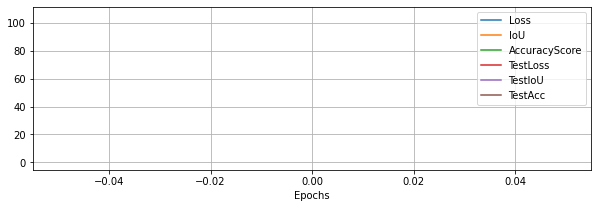

In [188]:
import pandas as pd
import matplotlib
#It downloads the image of the graphic
if hist: 
  for i in range(len(hist)):
    df = pd.DataFrame(hist[i])
    df.plot(grid=True,figsize=(10,3),xlabel='Epochs')
    matplotlib.pyplot.savefig('/content/drive/MyDrive/TFG/Modelos/Models Multilayer/Graphics/'+f'{ModelArchitecture}_{LearningRate}.png')

In [190]:
#It downloads the pretrained model 
torch.save(model.state_dict(),'/content/drive/MyDrive/TFG/Modelos/Models Multilayer/Pretrained Models/'+f'{ModelArchitecture}_lr_{LearningRate}.pt' )

In [193]:
#Overwriting model data into Results text file
f = open('/content/drive/MyDrive/TFG/Modelos/Models Multilayer/ResultsMultiLayer.txt', 'a')
f.write(f'\nModel:{ModelArchitecture}, BatchSize:{BatchSize}, Learning rate:{LearningRate}, Epochs:{Epochs}, Early Stopping:{EarlyStopping}, Train Dataset Length:{Train_Length}, Data Augmentation:{Augmentation}\nTest Loss:{best_loss}, Test IoU:{best_IoU}, Test Accuracy:{best_acc}')
f.close()

# Evaluation

In [194]:
pretrained_list = []
pretrained_list = [i for i in os.listdir('/content/drive/MyDrive/TFG/Modelos/Models Multilayer/Pretrained Models')]

In [207]:
#@title Do you want to upload a model?
Yes = True #@param {type:"boolean"}
if Yes:
  for i in pretrained_list: 
    print('\n' + i)
  #@markdown Select the architecture (must coincide with the one in Insert)
  Architecture = "resnet_50" #@param ["resnet_50", "resnet_101", "deeplabv3_resnet50", "deeplabv3_resnet101"]
  #@markdown Available models are shown below if 'Yes' is selected. Copy and insert the name in the 'Insert' tag
  Insert = 'resnet_50_lr_0.1.pt' #@param {type:"string"}
  params['model_name'] = Architecture
  if params['model_name']=='resnet_50':
    params['model']  = resnet_50
  elif params['model_name']=='resnet_101':
    params['model']  = resnet_101
  elif params['model_name']=='deeplabv3_resnet50':
    params['model']  = deeplabv3_resnet50_train
  elif params['model_name']=='deeplabv3_resnet101':
    params['model']  = deeplabv3_resnet101_train
 


resnet_50_lr_0.1.pt

resnet_50_lr_0.01.pt

resnet_50_lr_0.001.pt

resnet_101_lr_0.1.pt

resnet_101_lr_0.01.pt

resnet_101_lr_0.001.pt


In [203]:
pretrained_model_path = '/content/drive/MyDrive/TFG/Modelos/Models Multilayer/Pretrained Models/' + Insert

In [204]:
#Evaluacion visual de resultados
def visual_eval(model, model_name, archivo=False):
  
  model.load_state_dict(torch.load(pretrained_model_path,map_location=torch.device('cpu')))
  model.eval()
  model.to(device)
  import random
  font1 = {'family':'serif','color':'blue','size':20}
  with torch.no_grad():
    fig, axes = plt.subplots(2, 3, figsize=(18,6))
    for i in range(2):
     random_number = random.randint(0, ( len(RetImgs)-1 ))
     if model_name == 'UNet':
        output = model(torch.tensor(IRetImgs[random_number]).unsqueeze(0).unsqueeze(0).to(device))[0]
     else:
        output = model(torch.tensor(IRetImgs[random_number]).unsqueeze(0).unsqueeze(0).to(device))['out']
     pred_mask = torch.argmax(output.squeeze(0), axis=0) #axis 0 lo hace en la dim del numero de imagenes (2) tomando los máximos de cada paraja de pixeles
     axes[i,0].imshow(IRetImgs[random_number])
     axes[i,0].set_title("Image",fontsize=20)
     axes[i,0].set_yticks([])
     axes[i,0].set_xticks([])
     axes[i,1].imshow(ColouredMasks[random_number])
     axes[i,1].set_title("Mask",fontsize=20)
     axes[i,1].set_yticks([])
     axes[i,1].set_xticks([])
     axes[i,2].imshow(np.array(pred_mask.cpu()))
     axes[i,2].set_title("Prediction",fontsize=20)
     axes[i,2].set_yticks([])
     axes[i,2].set_xticks([])
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    plt.show()
    return pred_mask.to('cpu'),IRetImgs[random_number],ColouredMasks[random_number]

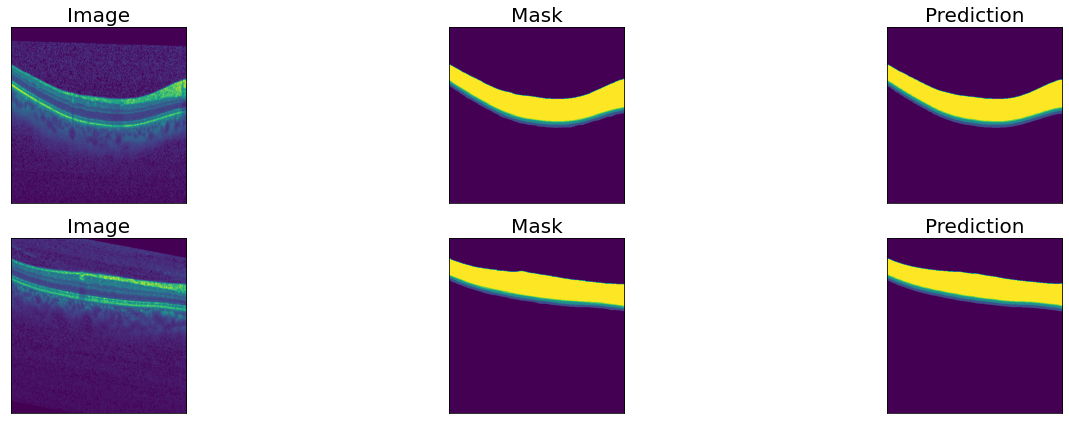

In [208]:
pred_mask, Original, mask = visual_eval(params['model'], params['model_name'])

In [199]:
def original_shape(pred_mask,index):
  import cv2
  import matplotlib.pyplot as plt
  pred_mask = np.array(pred_mask).astype('float32')
  output = cv2.resize(pred_mask,(shape_img[index][1],shape_img[index][0]))
  return output

In [200]:
def TORGB(img):
  B = [0,1,2,3,4]
  A1 = [0,255,0,0,255]
  A2 = [0,255,255,0,0]
  A3 = [0,0,0,255,127]
  A = [A1,A2,A3]
  var = np.array(img).astype('uint8')
  three_channel = []
  three_channel.append(var.copy())
  three_channel.append(var.copy())
  three_channel.append(var.copy())

  for position in range(len(three_channel)):
    for i in range(three_channel[position].shape[0]): 
      for j in range(three_channel[position].shape[1]): 
        if three_channel[position][i,j] in B: 
            three_channel[position][i,j] = A[position][three_channel[position][i,j]]
  return np.transpose(three_channel,(1,2,0))


In [201]:
DownloadResults = True #@param {type:"boolean"}
import shutil,os,torch
from PIL import Image
TestColouredMasks = ColouredMasks[Train_Length:]
if DownloadResults == True:
  if Yes == True:
    model = params['model'].to('cpu')
    model.eval
    pretrained = torch.load(pretrained_model_path,map_location=torch.device('cpu'))
    model.load_state_dict(pretrained) 
  newpath = ['/content/Predictions/Prediction', '/content/Predictions/Original','/content/Predictions/Mask']
  if (os.path.exists('/content/Predictions')):
    shutil.rmtree('/content/Predictions')
  for i in newpath:
      os.makedirs(i)
  i=0
  for img in IRetImgs[Train_Length:]:
    with torch.no_grad():
      output = params['model'](torch.tensor(img).unsqueeze(0).unsqueeze(0))['out']
    pred_mask = torch.argmax(output.squeeze(0), axis=0)
    pred_mask = original_shape(pred_mask,i)
    pred_mask = TORGB(pred_mask)
    img = original_shape(img,i)
    ColorMask = original_shape(TestColouredMasks[i],i)
    ColorMask = TORGB(ColorMask)

    pred_mask = Image.fromarray(np.array(pred_mask).astype('uint8'))
    img = Image.fromarray((img*255).astype('uint8'))
    ColorMask = Image.fromarray(np.array(ColorMask).astype('uint8'))

    pred_mask.save(f'/content/Predictions/Prediction/Prediction{i}.png')
    img.save(f'/content/Predictions/Original/Original{i}.png')
    ColorMask.save(f'/content/Predictions/Mask/Mask{i}.png')
    i+=1
  shutil.make_archive('/content/drive/MyDrive/TFG/Prediction Images/Predictions', 'zip', '/content/Predictions')
  


KeyboardInterrupt: ignored

In [ ]:
drive.flush_and_unmount()